## Imports

In [1]:
import sys
sys.path.append('../')
import gc
import pandas as pd
import numpy as np

from src.fetch_data import DataLoader
from src.exploration import Analysis
from src.cleaning import CleanDataFrame
from src.visualization import Plotters
from src.processing import PreProcess


import matplotlib.pyplot as plt



cleaner = CleanDataFrame()
analyzer = Analysis()
preprocessor = PreProcess()
plotters = Plotters(w=6, h=4)

# pd.options.plotting.backend = 'matplotlib'
plt.rcParams.update({'font.size': 24})
# plt.rcParams.update({'xtick.labelsize': 'large'})
# plt.rcParams.update({'ytick.labelsize': 'large'})
plt.rcParams.update({'legend.fontsize': 24})
%matplotlib inline
# plt.rcParams.keys()



## Fetch the dataframes

In [10]:
# Then load the raw sales data
data_path = 'data/merged/train.csv'
version = 'merged_v3'
repo = '../'

train_df = DataLoader.dvc_get_data(data_path, version, repo)
train_df['Date'] = pd.to_datetime(train_df['Date'])
# Finally load the test data
data_path = 'data/merged/test.csv'
version = 'merged_v3'
repo = '../'

test_df = DataLoader.dvc_get_data(data_path, version, repo)
test_df['Date'] = pd.to_datetime(test_df['Date'])

/home/hat/dev-env/10Acadamy/week_3/Rossmann-Pharmaceuticals-Sales-Forcast/notebooks/../src/fetch_data.py:28: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(content), sep=",")
DataLoaderLogger - INFO - DVC: CSV file read with path: data/merged/train.csv | version: merged_v3 | from: ../
DataLoaderLogger - INFO - DVC: CSV file read with path: data/merged/test.csv | version: merged_v3 | from: ../


# 

# Features correlation to target

In [3]:
train_df.corr()["Sales"].sort_values(ascending=False)


Sales                       1.000000
Customers                   0.894711
Open                        0.678472
Promo                       0.452345
SchoolHoliday               0.085124
Store                       0.005126
CompetitionDistance        -0.018869
CompetitionOpenSinceYear   -0.038540
Promo2SinceWeek            -0.044143
Promo2                     -0.091040
Promo2SinceYear            -0.091056
DayOfWeek                  -0.462125
Name: Sales, dtype: float64

Let me fist check the test data to see what my models would be infering with.

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         41088 non-null  int64         
 1   Store                      41088 non-null  int64         
 2   DayOfWeek                  41088 non-null  int64         
 3   Date                       41088 non-null  datetime64[ns]
 4   Open                       41077 non-null  float64       
 5   Promo                      41088 non-null  int64         
 6   StateHoliday               41088 non-null  object        
 7   SchoolHoliday              41088 non-null  int64         
 8   StoreType                  41088 non-null  object        
 9   Assortment                 41088 non-null  object        
 10  CompetitionDistance        41088 non-null  float64       
 11  CompetitionOpenSinceMonth  41088 non-null  object        
 12  Comp

The number of Customer has the highes correlation with the Sales, but we don't have that in our test data. So, first I will filter the columns that are in my test data. There are also some columns that are in training data but not in test. so, I will drop those. 

All this is implemented in the `PreProcessor` class

In [5]:
test_colunns = set(test_df.columns)
train_columns = set(train_df.columns)
print(len(test_colunns), len(train_columns))
common_columns = test_colunns.intersection(train_columns)
print(len(common_columns))

17 18
16


In [6]:
# train_df.info()

In [7]:
# common_columns

In [8]:
# train_columns.difference(test_colunns)

And these are the columns that are common in both. Other than the Customer column, the other will be recreated next. I'm just removing them the data, to help me test the pre-processing pipeline I am building.


In [6]:
# train_df.drop(columns=list(train_columns.difference(test_colunns)),
#               inplace=True)



- Raw data comes in
- Feature engineering
- Droping columns
- Encoding categoricals
- Scalling


I have created a module for feature engineering, which I will utilize here.

In [11]:
preped_train_df = preprocessor.transform(train_df)

PreProcessorLogger - INFO - Dropped 16 columns since they are not in the test data
PreProcessorLogger - INFO - 9 new columns added to the dataframe
PreProcessorLogger - INFO - Feature enginerring completed


In [16]:
preped_train_df['Sales'] = train_df['Sales']
preped_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Assortment                 1017209 non-null  object        
 1   CompetitionDistance        1017209 non-null  float64       
 2   CompetitionOpenSinceMonth  1017209 non-null  object        
 3   CompetitionOpenSinceYear   1017209 non-null  float64       
 4   Date                       1017209 non-null  datetime64[ns]
 5   DayOfWeek                  1017209 non-null  int64         
 6   Open                       1017209 non-null  int64         
 7   Promo                      1017209 non-null  int64         
 8   Promo2                     1017209 non-null  int64         
 9   Promo2SinceWeek            1017209 non-null  float64       
 10  Promo2SinceYear            1017209 non-null  float64       
 11  PromoInterval              1017209 no

<AxesSubplot:>

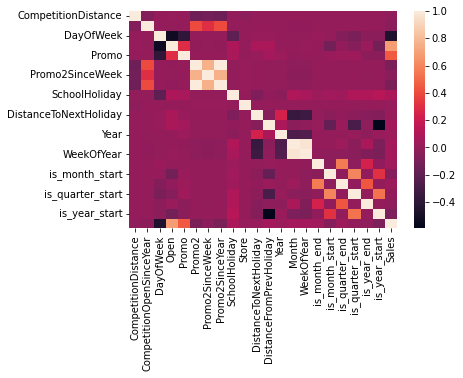

In [20]:
import seaborn as sns
sns.heatmap(preped_train_df.corr())
# preped_train_df['Sales']


In [21]:
cleaner.get_numerical_columns(preped_train_df)

['CompetitionDistance',
 'CompetitionOpenSinceYear',
 'DayOfWeek',
 'Open',
 'Promo',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'SchoolHoliday',
 'Store',
 'DistanceToNextHoliday',
 'DistanceFromPrevHoliday',
 'Year',
 'Month',
 'WeekOfYear',
 'Sales']

In [22]:
cleaner.get_categorical_columns(preped_train_df)

['Assortment',
 'CompetitionOpenSinceMonth',
 'PromoInterval',
 'StateHoliday',
 'StoreType']

The encodeing and scaling of these will be handled by the training pipeline. This will be in the modeling notebook